# Spatial Modelling with Pyspatialml

## Example Spatial Prediction using the Meuse Dataset

Here we are using the meuse dataset which is included in the pyspatialml package as an example of performing a spatial model and prediction. We can access the datasets using the `pyspatialml.datasets.meuse_dataset` module:

In [1]:
from copy import deepcopy
import os
import geopandas as gpd
import numpy as np
from pyspatialml import Raster
from pyspatialml.preprocessing import xy, distance_to_corners, distance_to_samples
import pyspatialml.datasets.meuse_dataset as ms

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%config InlineBackend.figure_format ='retina'

Various terrain-related predictors have been pregenerated:

In [2]:
predictor_files = ms.predictors
training_pts_file = ms.meuse
predictor_files

['/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/chnl_dist.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/dem.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/dist.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/ffreq.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/landimg2.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/landimg3.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/landimg4.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/mrvbf.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/rsp.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/slope.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/soil.tif',
 '/Users/steven/GitHub/Pyspatialml/pyspatialml/datasets/twi.tif']

## Creating a `Raster` Object

The raster datasets in the meuse module are aligned in terms of their extent and coordinate reference systems. We can 'stack' these into a Raster class so that we can perform machine learning related operations on the set of rasters:

In [3]:
stack = Raster(predictor_files)

We can store matplotlib cmaps as an attribute within each layer in the Raster:

In [4]:
stack.chnl_dist.cmap = 'RdBu'
stack.dem.cmap = 'terrain'
stack.dist.cmap = 'Reds'
stack.ffreq.cmap = cm.get_cmap('Set1', 3)
stack.ffreq.cmap = cm.get_cmap('Set1', 3)
stack.landimg2.cmap = 'Greys'
stack.landimg3.cmap = 'Greys'
stack.landimg4.cmap = 'Greys'
stack.landimg4.cmap = 'Greys'
stack.mrvbf.cmap = 'jet'
stack.rsp.cmap = 'gnuplot2'
stack.slope.cmap = 'PuRd'
stack.soil.cmap = cm.get_cmap('Set2', 3)
stack.twi.cmap = 'coolwarm'

Plot the predictors in the Raster object as a raster matrix:

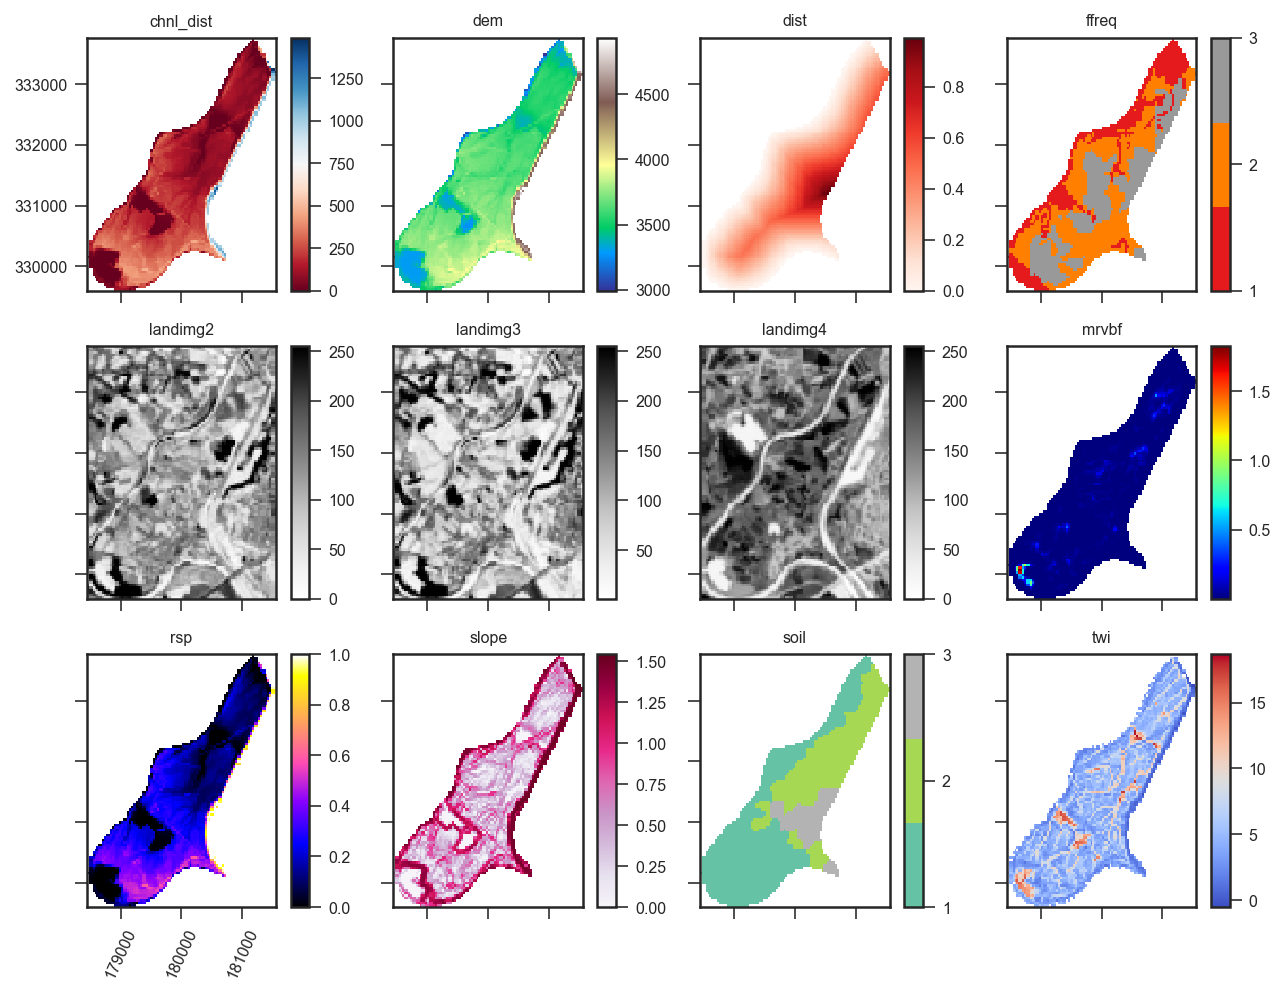

In [5]:
mpl.style.use('seaborn-ticks')
fig, axs = stack.plot(figsize=(9, 7))

# adjust the colorbar ticks on subplot 3
ax = axs.flatten()[3]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])

# adjust the colorbar ticks on subplot 10
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])

# adjust the ticklabels rotation on subplot 8
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

fig.tight_layout()
plt.show()

## Feature Engineering

We want the prediction results to be depend on the spatial locations of the training data. So to include spatial information, coordinate grids can be generated and added to the Raster object:

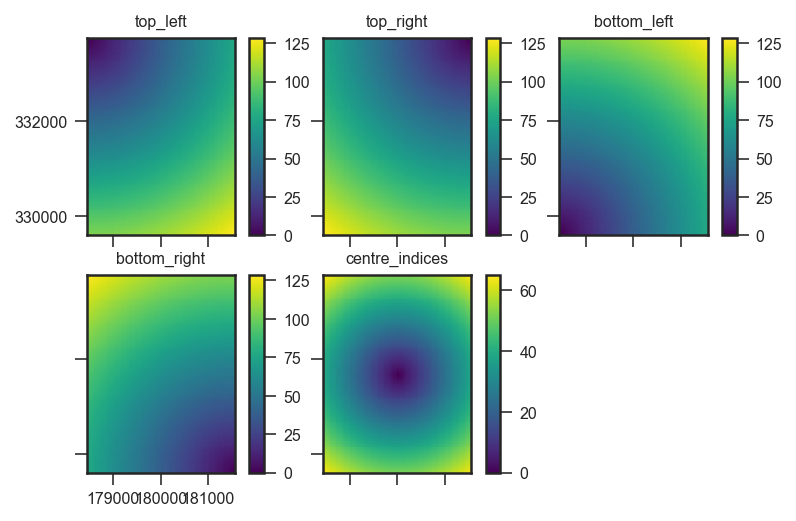

In [6]:
xy_coordinates = xy(stack.iloc[0])
edms = distance_to_corners(stack.iloc[0])
edms.plot()
plt.show()

Append them to the Raster object:

In [7]:
stack.append([xy_coordinates, edms])

Plot the new predictors:

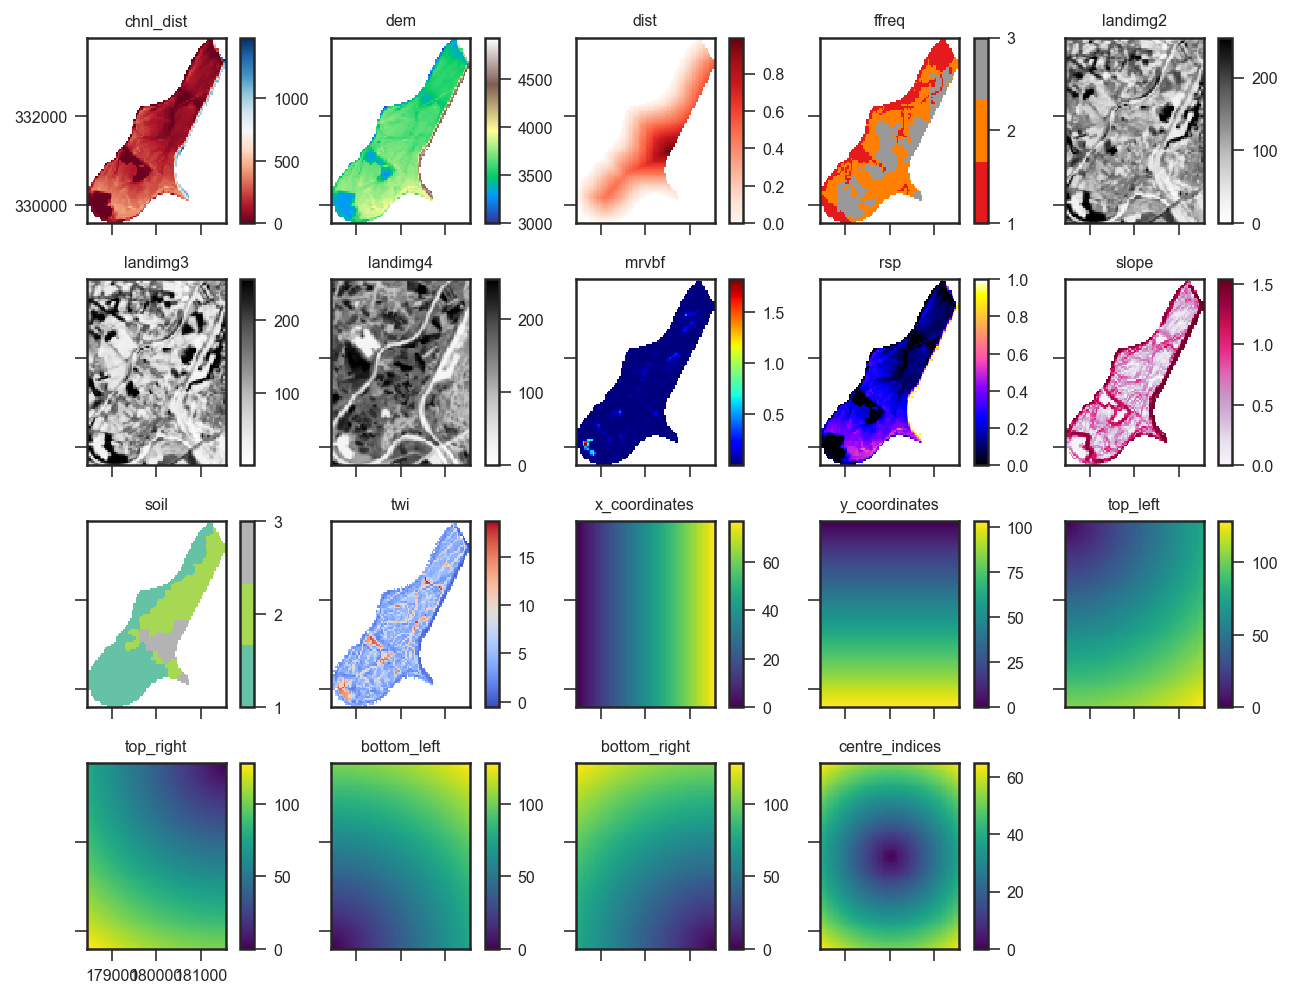

In [8]:
mpl.style.use('seaborn-ticks')
fig, axs = stack.plot(figsize=(9, 7))

# adjust the colorbar ticks on subplot 3
ax = axs.flatten()[3]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])

# adjust the colorbar ticks on subplot 10
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])

# adjust the ticklabels rotation on subplot 8
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

fig.tight_layout()
plt.show()

The area that is filled by some of the grids is different. This doesn't matter for the prediction because pixels in the Raster object that include some NaNs in some of the layers will be removed. However, the plots could potentially be given a cleaner look. We can use the Raster.intersect method to fix this:

In [9]:
stack = stack.intersect()

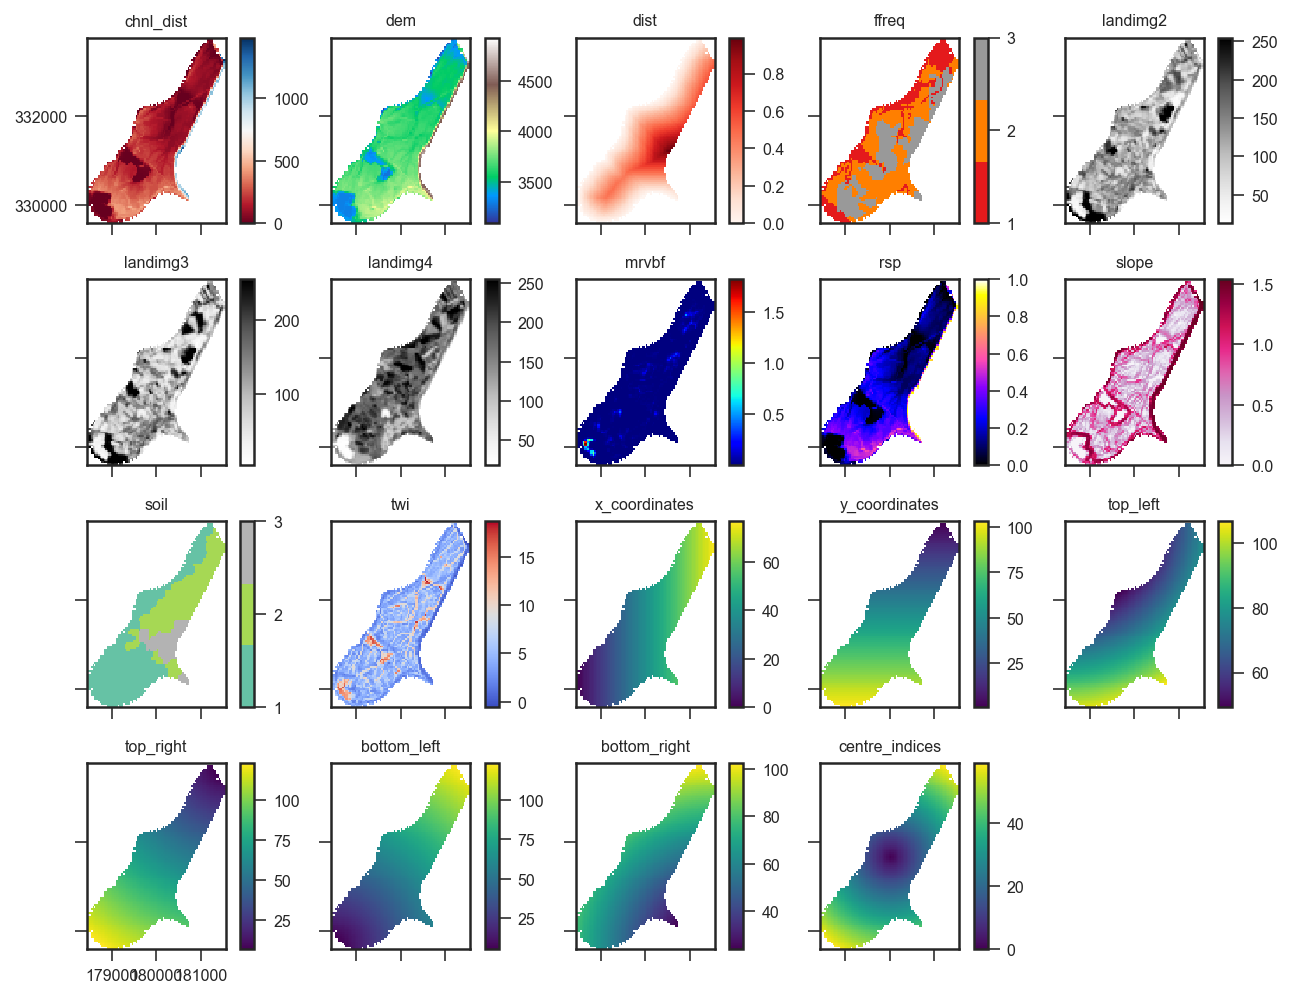

In [10]:
mpl.style.use('seaborn-ticks')
fig, axs = stack.plot(figsize=(9, 7))

# adjust the colorbar ticks on subplot 3
ax = axs.flatten()[3]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])

# adjust the colorbar ticks on subplot 10
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])

# adjust the ticklabels rotation on subplot 8
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

fig.tight_layout()
plt.show()

## Read the Meuse Dataset

In [11]:
training_pts = gpd.read_file(training_pts_file)
training_pts.head()

,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,geometry
0,11.7,85.0,299.0,1022.0,7.909,0.001358,13.6,1,1,1,Ah,50.0,POINT (181072 333611)
1,8.6,81.0,277.0,1141.0,6.983,0.012224,14.0,1,1,1,Ah,30.0,POINT (181025 333558)
2,6.5,68.0,199.0,640.0,7.800,0.103029,13.0,1,1,1,Ah,150.0,POINT (181165 333537)
3,2.6,81.0,116.0,257.0,7.655,0.190094,8.0,1,2,0,Ga,270.0,POINT (181298 333484)
4,2.8,48.0,117.0,269.0,7.480,0.277090,8.7,1,2,0,Ah,380.0,POINT (181307 333330)


Plot the training points:

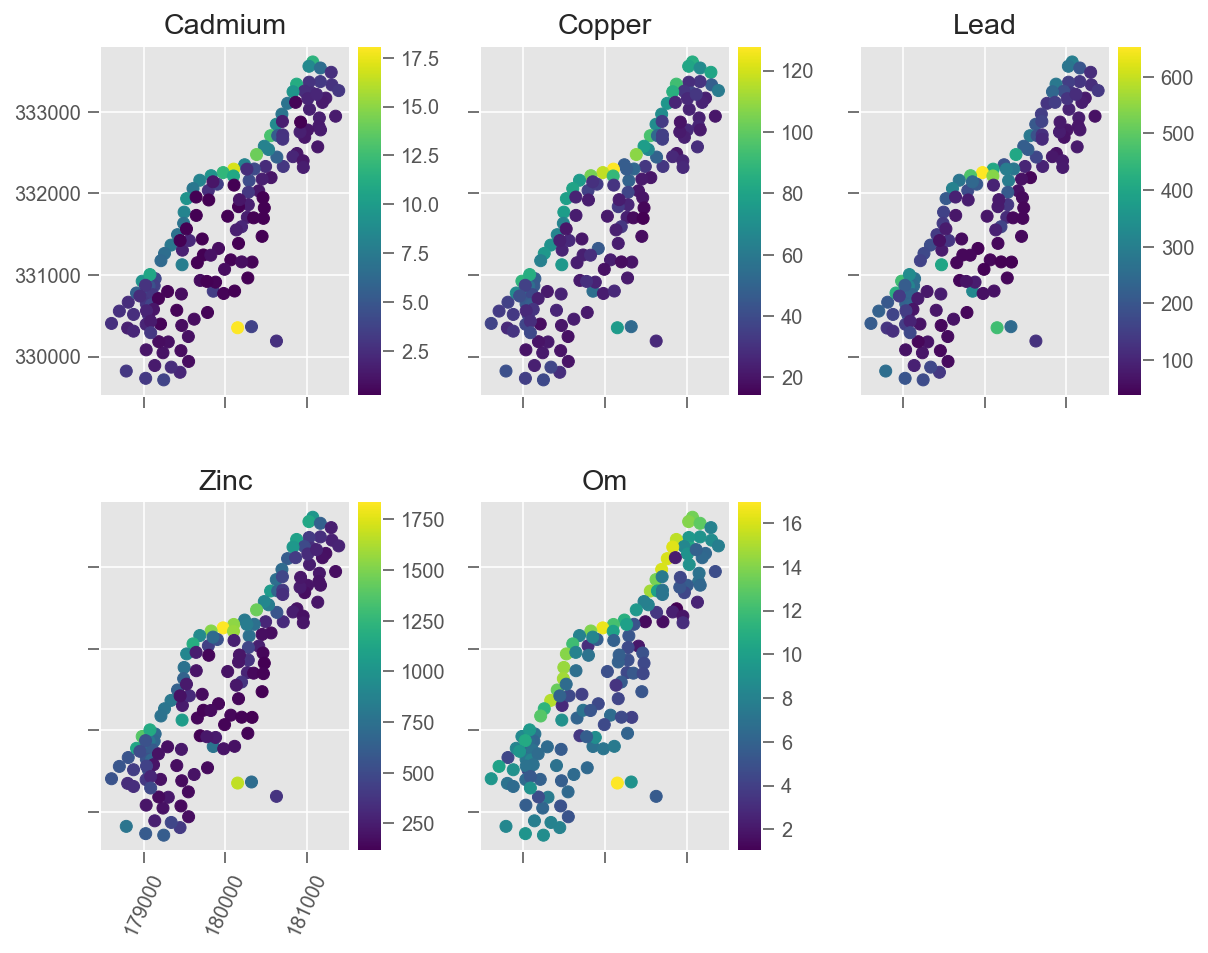

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')

fig, axs = plt.subplots(2, 3, figsize=(8.5, 7))

for i, (ax, target) in enumerate(zip(axs.ravel(), ['cadmium', 'copper', 'lead', 'zinc', 'om'])):
    ax.set_title(target.title())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.05)
    training_pts.plot(column=target, legend=True, ax=ax, cax=cax, cmap='viridis')

    if i != 0:
        ax.set_yticklabels([])
    
    if i != 3:
        ax.set_xticklabels([])
    else:
        ax.tick_params(axis='x', labelrotation=65)
    
fig.delaxes(axs.flatten()[i+1])
plt.tight_layout()
plt.show()

## Extract Raster Values at the Training Point Locations

In [65]:
training_df = stack.extract_vector(training_pts, field='lead')
training_df['cadmium'] = stack.extract_vector(training_pts, field='cadmium')['cadmium']
training_df['copper'] = stack.extract_vector(training_pts, field='copper')['copper']
training_df['zinc'] = stack.extract_vector(training_pts, field='zinc')['zinc']
training_df.head()

,lead,chnl_dist,dem,dist,ffreq,landimg2,landimg3,landimg4,mrvbf,rsp,slope,soil,twi,geometry,cadmium,copper,zinc
0,299.0,0.000000,3214.0,0.001358,1.0,97.0,92.0,192.0,3.523824e-06,0.000000,1.423307,1.0,4.054781,POINT (181072 333611),11.7,85.0,1022.0
1,277.0,79.849854,3402.0,0.012224,1.0,160.0,183.0,183.0,9.879866e-06,0.082085,1.286004,1.0,2.724715,POINT (181025 333558),8.6,81.0,1141.0
2,199.0,0.000000,3277.0,0.103029,1.0,178.0,209.0,179.0,1.340742e-03,0.000000,0.674711,1.0,8.884459,POINT (181165 333537),6.5,68.0,640.0
3,116.0,184.743164,3563.0,0.190094,1.0,114.0,135.0,152.0,6.547428e-07,0.192325,1.413479,2.0,1.638870,POINT (181298 333484),2.6,81.0,257.0
4,117.0,16.768555,3406.0,0.277090,1.0,133.0,154.0,151.0,1.588824e-03,0.016689,0.531276,2.0,4.361476,POINT (181307 333330),2.8,48.0,269.0


## Fit a Machine Learning Model

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

et = ExtraTreesRegressor(n_jobs=-1)
et = Pipeline([
    ('ohe', OneHotEncoder())
])

X = training_df.loc[:, stack.names]
y = training_df.loc[:, ['lead', 'zinc', 'copper', 'cadmium']]
et.fit(X, y)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(categorical_features=None, categories=None,
                               drop=None, dtype=<class 'numpy.float64'>,
                               handle_unknown='error', n_values=None,
                               sparse=True))],
         verbose=False)

In [68]:
# cross validate
from sklearn.model_selection import cross_validate
scores = cross_validate(et, X, y, scoring='neg_mean_squared_error', cv=10, n_jobs=1)
rmse = np.sqrt(-scores['test_score']).mean()
rmse

124.5802875034044

## Prediction on the Raster object

In [75]:
preds = stack.predict(et, block_shape=(256, 256))
preds.rename({old: new for old, new in zip(preds.names, ['lead', 'zinc', 'copper', 'cadmium'])})

  0%|          | 0/1 [00:00<?, ?it/s]


Plot the results:

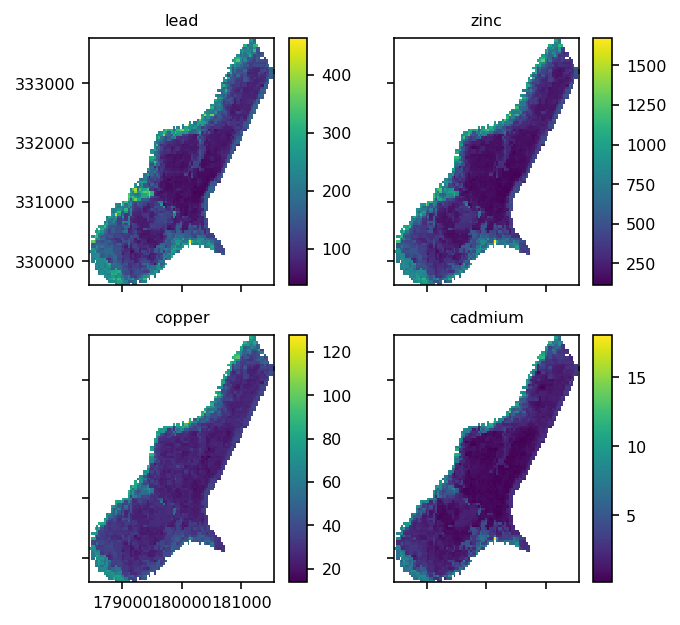

In [76]:
preds.plot()
plt.show()